In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 데이터셋

---

- 훈련데이터 6-12학년이 작성한 에세이에 대해 전문평가자들이 작문에서 발견되는 보편적인 요소에 주석을 첨부한 데이터 `144,293`건
- 훈련데이터 문서개수: `15,594`개
- 테스트데이터 문서개수: `10,000`개

**요구사항**
1. 에세이의 주석을 예측하는 문제
2. 먼저 각 에세이를 별개의 수사적 요소와 논쟁적 요소(즉, 담화 요소)로 분할하고 각 요소를 다음 중 하나로 분류해야한다.

**각 요소(총 7개)를 다음 중 하나로 분류해야합니다.**

원문
- Lead - an introduction that begins with a statistic, a quotation, a description, or some other device to grab the reader’s attention and point toward the thesis
- Position - an opinion or conclusion on the main question
- Claim - a claim that supports the position
- Counterclaim - a claim that refutes another claim or gives an opposing reason to the position
- Rebuttal - a claim that refutes a counterclaim
- Evidence - ideas or examples that support claims, counterclaims, or rebuttals.
- Concluding Statement - a concluding statement that restates the claims

---
번역
- Lead(서론): 독자의 관심을 끌고 논문을 가리키는 서론(통계, 인용문, 설명등)
- Position(주장): 주요 질문에 대한 의견 또는 결론
- Claim(근거): Position에 대한 근거
- Counterclaim(반론):  다른 주장을 반박하거나 그 입장에 반대 이유를 제시하는 주장
- Rebuttal(반박):  반론을 반박하는 주장
- Evidence(증거):  주장, 반론, 반박에 대한 증거 
- Concluding Statement(결론):  논거에 대한 최종 결론

In [ ]:
# train 데이터셋
train = pd.read_csv("../input/feedback-prize-2021/train.csv")

In [ ]:
# 훈련데이터 수
len(train)

In [ ]:
# 0~9번까지 423A1CA112E2 문서에 담긴 담화들을 보여줍니다.
# 10번부터는 A8445CABFECE 문서의 담화가 시작됩니다.
# 즉 문서를 discourse 별로 segmentation 했다고 보면 됩니다.
train.head(11)

### 피쳐 설명

- 하나의 문서에 여러개의 담화 요소가 나타납니다.
- 각 담화 요소는 ID(`discourse_id`)를 가지며 시작, 종료위치(`discourse_start`, `discourse_end`)를 가집니다.
- `discourse_text`: 담화 요소에 있는 문장들입니다.(단문, 복문)
- `discourse_type`: 정답 클래스입니다.
- `discourse_type_num`: 정답 클래스가 여러번 나타날 경우, `클래스1`, `클래스2` 등으로 나타납니다.
- `predictionstring`: 예측에 필요한 단어 색인인데 `discourse_text`와 관련이 있어보입니다. 예를들어 1번째 담화의 predictionstring이 1~10일때 그 다음 담화의 predictionstring은 11부터 시작합니다.
- `prectionstring` 피쳐에 [Issue](https://www.kaggle.com/competitions/feedback-prize-2021/discussion?search=predictionstring)가 있는 것 같으니 확인바랍니다.


--- 
```
원문
id - ID code for essay response
discourse_id - ID code for discourse element
discourse_start - character position where discourse element begins in the essay response
discourse_end - character position where discourse element ends in the essay response
discourse_text - text of discourse element
discourse_type - classification of discourse element
discourse_type_num - enumerated class label of discourse element
predictionstring - the word indices of the training sample, as required for predictions
```
---
```
번역
id - 문서 id 코드
diction_id - 담화 요소의 ID 코드
diction_start - 문서에서 담화 요소가 시작되는 문자 위치
diction_end - 문서에서 담화 요소가 끝나는 문자 위치
diction_text - 담화 요소 텍스트
diction_type - 담화 요소의 분류(타겟)
diction_type_num - 담화 요소의 열거된 클래스 라벨 (같은 문서에 타겟이 여러번 나타날 경우 클래스1, 클래스2, 클래스3 ... 등으로 나타난다.)
predictionstring - 예측에 필요한 교육 샘플의 단어 색인
```

In [ ]:
# 예측해야하는 타겟클래스
target_lst = list(train['discourse_type'].unique())
print(target_lst)

In [ ]:
# 훈련데이터에 있는 총 문서 개수
doc_id = list(train['id'].unique())
print(len(doc_id))

In [ ]:
# 담화문 예시
for i in range(5):
    for col in train.columns:
        print(f"{col} : {train[col][i]}")
    
    print("---" * 30)

# 문서를 어떻게 예측해야하는지 

- `D46BCB48440A` 라는 docid를 가진 문서에는 7개의 다른 클래스를 가진 문장들이 존재한다.
- train 데이터를 학습한 모델이 테스트셋에 있는 `D46BCB48440A`라는 문서의 문장들을 클래스를 정확히 예측할 수 있어야한다.
- 예측 결과를 시각화한 결과는 다음과 같다.

In [ ]:
from glob import glob
# 문서에 있는 문장 출력
for file in glob("../input/feedback-prize-2021/test/*"):
    filename = file.split("/")[-1]
    if filename == "D46BCB48440A.txt":
        with open(file, 'r', encoding='utf-8') as f:
            print(f.read())

### 문장 클래스 예측 결과 시각화

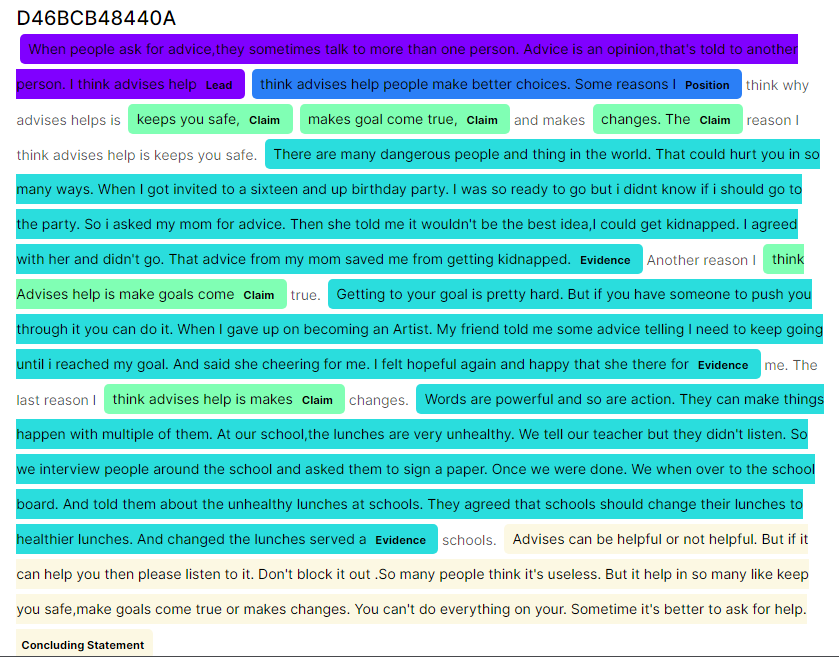